In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from p6_rotations import topology_to_list
from p9_sp_clusters_data import *
from joblib import dump, load


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
#import xgboost as xgb

df = pd.DataFrame(data=list_of_sp_clusters, columns = ['full_notation','energy','SCF_steps','magnetism','time_of_calculation'])
suma = 0
for i in range(len(df)):
    suma+=float(df['time_of_calculation'].iloc[i][:-1])
print(suma/len(df)*60)

2023-05-15 18:47:53.501522: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-15 18:47:53.501548: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2784.2523882896753


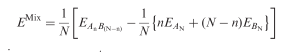


In [2]:
#function that transcribe energy to reduce energy

#first value is nickel energy, second is cooper
monomet_cl_energy = {'MO':(-74.568295,-57.156901),
                                         'MOCOM':(-79.855113,-62.216739),
                                         'MOCMHnbond':(-79.004707,-61.301059),
                                         'MC':(-78.378661,-60.821898),
                                         'MOCM':(-75.478348,-57.428965)}
#hydrogen corrections
monomet_cl_energy = {'MO':(-74.568295,-57.156901),
                                         'MOCOM':(-79.855113+3.344,-62.216739+3.344),
                                         'MOCMHnbond':(-79.004707+3.344,-61.301059+3.344),
                                         'MC':(-78.378661+3.344,-60.821898+3.344),
                                         'MOCM':(-75.478348+3.344,-57.428965+3.344)}

def energy_redu(df):
    if 'energy' in df.columns and 'no_nickel' in df.columns and 'joining_type' in df.columns:
        print('Appriopiate columns are present in database')
        df['redu_energy'] = df['no_nickel']
        for i in range(len(df)):
            energy = -df['energy'].iloc[i]
            nickel_part = monomet_cl_energy[df['joining_type'].iloc[i]][0]
            copper_part = monomet_cl_energy[df['joining_type'].iloc[i]][1]
            nickel = int(df['no_nickel'].iloc[i])           
            df['redu_energy'].iloc[i] = (energy - (1/13)*(nickel*nickel_part + (13-nickel)*copper_part))
        return df
    else:
        print('Given database is missing at least one column')

        
test = energy_redu(benchmark1)
test = test[test['joining_type'] != 'MOCM']
sns.scatterplot(data=test, x=test['full_notation'], y=test['energy'], hue=test['c_atom'])

test[['full_notation','c_atom','topology']]

NameError: name 'benchmark1' is not defined

## Data Preprocessing


In [40]:
#importing data frames
all_csv = pd.read_csv('all.csv').drop(['Unnamed: 0','all_corners_comb','all_edges_comb','no_edges_comb','no_corners_comb','all_comb'],axis=1)
df = pd.DataFrame(data=list_of_sp_clusters, columns = ['full_notation','energy','SCF_steps','magnetism','time_of_calculation'])
real_benchmark = pd.read_csv('benchmark_ds.csv').drop(['index','Unnamed: 7'],axis=1)

#full_notation of real_benchmark = no_cluster + joining_type + rotation

#creating new columns in df:
for column in ['no_nickel','number','joining_type','first_atom','second_atom','topology','c_atom','mass_center','shortest_paths','conformation','bonds']:
    df[column] = df['magnetism'] 

#gathering data from full notation columns
df = df.assign(number = df['full_notation'].apply(lambda x: x.split('_')[0]),
              joining_type = df['full_notation'].apply(lambda x: x.split('_')[1]),
              first_atom = df['full_notation'].apply(lambda x: x.split('_')[2]),
              second_atom = df['full_notation'].apply(lambda x: x.split('_')[3]),
              energy = df['energy'].apply(lambda x: float(x[1:])))

for cluster in range(len(df)):
    if df['joining_type'].iloc[cluster] in ['MOCOM','MOCMHnbond','MC']:
        df['energy'].iloc[cluster] -= 3.344

#splitting shortest paths, conformation and bonds
for column in ['ni_ncentre','ni_centre','cu_ncentre','cu_centre','0ni','8ni','17ni','25ni','33ni','42ni','50ni', 'nini','cucu','nicu','type_of_first_atom','type_of_second_atom', 'hydrogen']:
    df[column] = df['magnetism']    

#gathering data from all.csv file and splitting shortest paths, conformation and bonds
for cluster in range(len(df)):
    for column in ['no_nickel','c_atom','mass_center','shortest_paths','conformation','bonds']:
        df[column].iloc[cluster] = all_csv[column].loc[int(df['number'].iloc[cluster])]
    for column in ['topology']:
        df[column].iloc[cluster] = topology_to_list(all_csv[column].loc[int(df['number'].iloc[cluster])])
    df['ni_ncentre'].iloc[cluster] = int(str(df['shortest_paths'].iloc[cluster].split(',')[0])[1:])
    df['ni_centre'].iloc[cluster] = int(df['shortest_paths'].iloc[cluster].split(',')[1])
    df['cu_ncentre'].iloc[cluster] = int(df['shortest_paths'].iloc[cluster].split(',')[2])
    df['cu_centre'].iloc[cluster] = int(str(df['shortest_paths'].iloc[cluster].split(',')[3])[:-1])
    df['0ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[0])[1:])
    df['50ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[6])[:-1])
    df['8ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[1]))
    df['17ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[2]))
    df['25ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[3]))
    df['33ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[4]))
    df['42ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[5]))
    df['nini'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[0])[1:])
    df['cucu'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[2])[:-1])
    df['nicu'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[1]))
    df['type_of_first_atom'].iloc[cluster] = df['topology'].iloc[cluster][df['first_atom'].iloc[cluster]]
    df['type_of_second_atom'].iloc[cluster] = df['topology'].iloc[cluster][df['second_atom'].iloc[cluster]]
    if df['joining_type'].iloc[cluster] in ['MOCOM','MOCM_H_n_bond','MC']:
        df['hydrogen'].iloc[cluster] = 1
    else:
        df['hydrogen'].iloc[cluster] = 0

print('len:', len(df))
print(df['joining_type'].unique())
print(df['no_nickel'].unique())

full_dataset = df.drop(['conformation','shortest_paths','bonds'],axis=1)
full_dataset = energy_redu(full_dataset)
full_dataset.head(10)



TypeError: string indices must be integers

In [28]:
#importing data frames
all_csv = pd.read_csv('all.csv').drop(['Unnamed: 0','all_corners_comb','all_edges_comb','no_edges_comb','no_corners_comb','all_comb'],axis=1)
df = pd.DataFrame(data=list_of_sp_clusters, columns = ['full_notation','energy','SCF_steps','magnetism','time_of_calculation'])
real_benchmark = pd.read_csv('benchmark_ds.csv').drop(['index','Unnamed: 7'],axis=1)

#creating full notation column in benchmark
real_benchmark = real_benchmark.assign(full_notation=lambda x: (str(x.no_cluster) + '_' + x.joining_type+'_'+x.rotation))

#gathering data from full notation columns


df = df.assign(number = lambda x: x.magnetism, joining_type = lambda x: x.magnetism, 
               first_atom = lambda x: x.magnetism, second_atom = lambda x: x.magnetism)

for cluster in range(len(df)):
    df['number'].iloc[cluster] = df['full_notation'].iloc[cluster].split('_')[0] 
    df['joining_type'].iloc[cluster] = df['full_notation'].iloc[cluster].split('_')[1]
    df['first_atom'].iloc[cluster] = int(df['full_notation'].iloc[cluster].split('_')[2])
    df['second_atom'].iloc[cluster] = int(df['full_notation'].iloc[cluster].split('_')[3])

df = df.assign(energy = lambda x: x.energy[1:].astype(float) -3.344)
print(df)
#splitting shortest paths, conformation and bonds
for column in ['ni_ncentre','ni_centre','cu_ncentre','cu_centre','0ni','8ni','17ni','25ni','33ni','42ni','50ni', 'nini','cucu','nicu','type_of_first_atom','type_of_second_atom', 'hydrogen']:
    df[column] = df['magnetism']    

#gathering data from all.csv file and splitting shortest paths, conformation and bonds
for cluster in range(len(df)):
    for column in ['no_nickel','c_atom','mass_center','shortest_paths','conformation','bonds']:
        df[column].iloc[cluster] = all_csv[column].loc[int(df['number'].iloc[cluster])]
    for column in ['topology']:
        df[column].iloc[cluster] = topology_to_list(all_csv[column].loc[int(df['number'].iloc[cluster])])
    df['ni_ncentre'].iloc[cluster] = int(str(df['shortest_paths'].iloc[cluster].split(',')[0])[1:])
    df['ni_centre'].iloc[cluster] = int(df['shortest_paths'].iloc[cluster].split(',')[1])
    df['cu_ncentre'].iloc[cluster] = int(df['shortest_paths'].iloc[cluster].split(',')[2])
    df['cu_centre'].iloc[cluster] = int(str(df['shortest_paths'].iloc[cluster].split(',')[3])[:-1])
    df['0ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[0])[1:])
    df['50ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[6])[:-1])
    df['8ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[1]))
    df['17ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[2]))
    df['25ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[3]))
    df['33ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[4]))
    df['42ni'].iloc[cluster] = int(str(df['conformation'].iloc[cluster].split(',')[5]))
    df['nini'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[0])[1:])
    df['cucu'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[2])[:-1])
    df['nicu'].iloc[cluster] = int(str(df['bonds'].iloc[cluster].split(',')[1]))
    df['type_of_first_atom'].iloc[cluster] = df['topology'].iloc[cluster][df['first_atom'].iloc[cluster]]
    df['type_of_second_atom'].iloc[cluster] = df['topology'].iloc[cluster][df['second_atom'].iloc[cluster]]
    if df['joining_type'].iloc[cluster] in ['MOCOM','MOCM_H_n_bond','MC']:
        df['hydrogen'].iloc[cluster] = 1
    else:
        df['hydrogen'].iloc[cluster] = 0

print('len:', len(df))
print(df['joining_type'].unique())
print(df['no_nickel'].unique())

full_dataset = df.drop(['conformation','shortest_paths','bonds'],axis=1)
full_dataset = energy_redu(full_dataset)
full_dataset.head(10)



           full_notation     energy SCF_steps magnetism time_of_calculation  \
0             58_MO_7_11        NaN        94      0.95              67.92m   
1          58_MOCOM_7_11 -73.755401       118      2.00             113.04m   
2              59_MO_1_6 -68.918785       109      1.00              79.86m   
3              59_MO_4_1 -68.873727        88      0.99              43.05m   
4              59_MO_7_6 -68.848183        86      1.00              56.84m   
..                   ...        ...       ...       ...                 ...   
644          141_MC_11_6 -73.605721        42      4.00              24.01m   
645           156_MC_5_4 -74.506286        51      4.00              36.18m   
646         190_MOCM_8_7 -76.699261        43      7.00              23.71m   
647  150_MOCMHnbond_5_10 -75.018709        45      4.00              26.44m   
648           187_MC_2_6 -78.141649        40      7.00              29.26m   

    number joining_type first_atom second_atom  
0 

KeyError: 'no_nickel'

## Creating Some Benchmarks

In [35]:
print('len of full_dataset:',len(full_dataset))
print('len of testing benchmark:', len(sp_on_benchmark_cases))
print(full_dataset['joining_type'].value_counts())
print(full_dataset['no_nickel'].value_counts())

equall_df = pd.DataFrame(columns=full_dataset.columns)
helpfull_df = pd.DataFrame(columns = full_dataset.columns)
#I need to gather the same number of whole cases --> I have exactly one type of every joinning type in no_nickel = 12 so I pick exactly one cluster for every number of nickel and joining type
for joining_type in ['MC','MOCOM','MOCMHnbond','MO','MOCM']:
    helpfull_df = full_dataset[(full_dataset['joining_type']==joining_type) & (full_dataset['no_nickel']<12) & (full_dataset['no_nickel']>1)]
    equall_df = pd.concat([equall_df, helpfull_df.sample(40)])

benchmark1 = pd.DataFrame(columns = full_dataset.columns)
for nickel in range(1,13):
    for joining_type in ['MC','MOCOM','MOCMHnbond','MO']:
        
        helpfull_df = ((full_dataset[(full_dataset['joining_type']==joining_type) & (full_dataset['no_nickel']==nickel)]))
        if len(helpfull_df) != 0:
            benchmark1 = pd.concat([benchmark1,helpfull_df])
benchmark1 = energy_redu(benchmark1)
#of course due to not converting some of clusters, exactly one data (1_MOCM) was missed, eqaul_df is the first benchmark data set
#another benchmarks is from sp_on_benchmark cluster
#no_nickel,shortest_paths,conformation,bonds
list_of_cluster_benchmark = pd.DataFrame(data = [
[180,['Ni', 'Cu', 'Cu', 'Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni'],10,1,0.03923,9, 10, 3, 3,0, 0, 0, 0, 6, 3, 3,54, 6, 24],
[165,['Ni', 'Cu', 'Cu', 'Cu', 'Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni'],9,1,0.0445,8, 9, 4, 4,0, 0, 0, 2, 6, 2, 2,46, 10, 28],
[190,['Ni', 'Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni'],12,1,0.01705,11, 12, 1, 1,0, 0, 0, 0, 0, 5, 7,72, 0, 12],
[146,['Ni', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni'],8,1,0.04651,7, 8, 5, 5,0, 0, 1, 3, 5, 2, 1,38, 14, 32],
[186,['Ni', 'Cu', 'Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni'],11,1,0.02846,10, 11, 2, 2,0, 0, 0, 0, 2, 6, 4,62, 2, 20],
[181,['Ni', 'Cu', 'Cu', 'Ni', 'Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni'],10,1,0.03234,9, 10, 3, 3,0, 0, 0, 1, 3, 6, 2,52, 4, 28],
[2,['Cu', 'Ni', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu'],1,0,0.01372,1, 1, 11, 12,7, 5, 0, 0, 0, 0, 0,0, 72, 12],
[4,['Cu', 'Ni', 'Ni', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu'],2,0,0.02363,2, 2, 10, 11,4, 6, 2, 0, 0, 0, 0,2, 62, 20],
[44,['Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu'],5,0,0.04318,5, 5, 7, 8,1, 2, 5, 3, 1, 0, 0,14, 38, 32],
[72,['Cu', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Ni', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu', 'Cu'],6,0,0.0481,6, 6, 6, 7,1, 0, 5, 5, 0, 1, 0,20, 32, 32]], columns = ['number','topology','no_nickel','c_atom','mass_center','ni_ncentre', 'ni_centre','cu_ncentre', 'cu_centre','0ni', '8ni', '17ni', '25ni', '33ni', '42ni','50ni', 'nini', 'cucu', 'nicu'])

benchmark2 = pd.DataFrame(data = sp_on_benchmark_cases, columns = ['full_notation','energy','SCF_steps','magnetism','time_of_calculation'])

for column in ['hydrogen','type_of_first_atom','type_of_second_atom','first_atom','second_atom','joining_type','number']:
     benchmark2[column] = benchmark2['full_notation']

for cluster in range(len(benchmark2)):
    benchmark2['number'].iloc[cluster] = int(benchmark2['full_notation'].iloc[cluster].split('_')[0])
    benchmark2['joining_type'].iloc[cluster] = benchmark2['full_notation'].iloc[cluster].split('_')[1]
    benchmark2['first_atom'].iloc[cluster] = int(benchmark2['full_notation'].iloc[cluster].split('_')[2])
    benchmark2['second_atom'].iloc[cluster] = int(benchmark2['full_notation'].iloc[cluster].split('_')[3])  
    if benchmark2['joining_type'].iloc[cluster] in ['MO','MOCM']:
        benchmark2['hydrogen'].iloc[cluster] = 1
    else:
        benchmark2['hydrogen'].iloc[cluster] = 0
    for bench in range(len(real_benchmark)):
        if benchmark2['full_notation'].iloc[cluster] == real_benchmark['full_notation'].iloc[bench]:
            benchmark2['energy'].iloc[cluster] = real_benchmark['energy'].iloc[bench]
    benchmark2['energy'].iloc[cluster] = float(str(benchmark2['energy'].iloc[cluster])[1:])
    
benchmark2 = benchmark2.merge(list_of_cluster_benchmark, left_on='number', right_on = 'number', validate='m:1')

for cluster in range(len(benchmark2)):
    benchmark2['type_of_first_atom'].iloc[cluster] = benchmark2['topology'].iloc[cluster][benchmark2['first_atom'].iloc[cluster]]
    benchmark2['type_of_second_atom'].iloc[cluster] = benchmark2['topology'].iloc[cluster][benchmark2['second_atom'].iloc[cluster]]

benchmark2['no_nickel'].unique()
benchmark2 = energy_redu(benchmark2)

len of full_dataset: 649
len of testing benchmark: 26
MO            229
MOCOM         216
MC             74
MOCMHnbond     70
MOCM           60
Name: joining_type, dtype: int64
6     213
7     160
5      83
4      72
3      40
2      21
8      15
1      12
11     10
9       9
10      9
12      5
Name: no_nickel, dtype: int64
Appriopiate columns are present in database


/tmp/ipykernel_13535/2869138919.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark2['type_of_first_atom'].iloc[cluster] = benchmark2['topology'].iloc[cluster][benchmark2['first_atom'].iloc[cluster]]
/tmp/ipykernel_13535/2869138919.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark2['type_of_second_atom'].iloc[cluster] = benchmark2['topology'].iloc[cluster][benchmark2['second_atom'].iloc[cluster]]


Appriopiate columns are present in database


/tmp/ipykernel_13535/3067606086.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['redu_energy'].iloc[i] = (energy - (1/13)*(nickel*nickel_part + (13-nickel)*copper_part))


## Functions to create ML model

In [32]:
def ada(X_train,X_test,y_train,y_test, estimators= [50,100,150,200,250,300], lr = [0.2,0.4,0.6,0.8,1,1.5,2,3]):
    
    best_acc = [0]
    for est in estimators:
        for learning_rate in lr:  
        
            model = AdaBoostRegressor(n_estimators=est, learning_rate=learning_rate)    
            model.fit(X_train, y_train)
            model_pred = model.predict(X_test)

            srednia_error = 0    

            for i in range(len(model_pred)):
                srednia_error+= np.sqrt((model_pred[i]-y_test[i])**2)            
            srednia_error /= len(model_pred)   

            acc = 1-(srednia_error/(max(y_test)-min(y_test)))   
            
            if acc > best_acc[0]:
                best_acc = [acc, 'ada',  'est:',est, 'learning rate:',learning_rate]
                dump(model, 'model_ada.joblib') 

            
            #print('acc:',acc, 'type of alg: ada', 'est:', est, 'learning rate:', learning_rate)       
    return(best_acc, y_test, model_pred)

def rf(X_train,X_test,y_train,y_test, estimators= [50,100,150,200,250,300]):
    
    best_acc = [0]
    for est in estimators:

        model = RandomForestRegressor(n_estimators=est)  
        
        model.fit(X_train, y_train)
        model_pred = model.predict(X_test)

        srednia_error = 0    
        for i in range(len(model_pred)):
            srednia_error+= np.sqrt((model_pred[i]-y_test[i])**2)            
        srednia_error /= len(model_pred)   

        acc = 1-(srednia_error/(max(y_test)-min(y_test)))   

        if acc > best_acc[0]:
            best_acc = [acc, 'rf', 'est:' , est,]
            dump(model, 'model_rf.joblib') 
        
        #print('acc:',acc, 'type of alg:', 'rf', 'est:', est)   
    
    return(best_acc, y_test, model_pred)

def brf(X_train,X_test,y_train,y_test, estimators= [50,100,150,200,250,300], lr = [0.2,0.4,0.6,0.8,1,1.5,2,3], md = [1,2,3,4,5]):
    
    best_acc = [0]
    for est in estimators:
        for learning_rate in lr:
            for max_depth in md:
    
                model = GradientBoostingRegressor(n_estimators=est, learning_rate=learning_rate, max_depth=max_depth)  

                model.fit(X_train, y_train)
                model_pred = model.predict(X_test)

                srednia_error = 0    

                for i in range(len(model_pred)):
                    srednia_error+= np.sqrt((model_pred[i]-y_test[i])**2)            
                srednia_error /= len(model_pred)   

                acc = 1-(srednia_error/(max(y_test)-min(y_test)))   

                if acc > best_acc[0]:
                    best_acc = [acc, 'brf', 'est:' ,est, 'learning rate:', learning_rate, 'max_depth:',max_depth]
                    dump(model, 'model_brf.joblib') 
                #print('acc:',acc, 'type of alg:', 'brf', 'est:', est, 'learning rate:', learning_rate, 'max depth:', max_depth)    

    return(best_acc, y_test, model_pred)

def svr(X_train,X_test,y_train,y_test, C_parameter = [0.2,0.4,0.6,0.8,1,1.5,2,3], degrees = [x for x in range(1,8)], epsilon = [x/10 for x in range(1,11)]):
    
    best_acc = [0]
    for C in C_parameter:
        for degree in degrees:
            for eps in epsilon:
            
                model = SVR(C=C,degree = degree, epsilon = eps)
                model.fit(X_train, y_train)
                model_pred = model.predict(X_test)

                srednia_error = 0    

                for i in range(len(model_pred)):
                    srednia_error+= np.sqrt((model_pred[i]-y_test[i])**2)            
                srednia_error /= len(model_pred)   

                acc = 1-(srednia_error/(max(y_test)-min(y_test)))   

                if acc > best_acc[0]:
                    best_acc = [acc, 'svr', 'C: ', C,'degree:', degree, 'eps:',eps]
                    dump(model, 'model_svr.joblib') 
                #print('acc:',acc, 'type of alg:' 'C:', C, 'degree:', degree, 'eps:', eps)   
    
    return(best_acc, y_test, model_pred)

def printing(model, y_test, nn=False):  
    frame = []

    if nn == True:
        for char in range(len(model)):
            preframe = []
            preframe.append(model[char][0])
            preframe.append(y_test[char])
            frame.append(preframe)  
    else:
        for char in range(len(model)):
            preframe = []
            preframe.append(model[char])
            preframe.append(y_test[char])
            frame.append(preframe) 
    frame = pd.DataFrame(data=frame, columns =['y_test','model_pred'])  
    scaler = MinMaxScaler()
    scaler.fit(frame)
    frame = scaler.transform(frame)
    frame = pd.DataFrame(data=frame, columns = ['y_test','model_pred']) 
    frame = frame.sort_values(by=['y_test']).reset_index(drop=True)
    acc = 1-(sum(((frame['model_pred']-frame['y_test'])**2)**(0.5))/len(frame))
    print(acc)
    markers = {"y_test": "s", "model_pred": "h"}
    ax = sns.scatterplot(data=frame, markers=markers, s = 110) 
    return ax, acc
def data_scaling(data):
    X = data.drop(['energy','first_atom','second_atom','SCF_steps','magnetism','time_of_calculation','number','full_notation','joining_type','topology'],axis=1)
    X = pd.get_dummies(data = X, columns = ['type_of_first_atom','type_of_second_atom'], drop_first=True)
    columns = X.columns
    minmax = pd.DataFrame(data=[[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,min(data['redu_energy'])],[13,1,0.05071,12,13,12,13,12,12,10,10,10,12,12,84,84,52,1,1,max(data['redu_energy'])]],columns=columns)
    y = np.asarray(data['redu_energy']).astype('float32')
    scaler = MinMaxScaler()
    scaler.fit(minmax)
    X = scaler.transform(X)
    X = pd.DataFrame(data=X,columns = columns)
    return X,y

def create_model(X, activation, n):
    
    model = Sequential()
    model.add(Dense(units=len(X.columns), activation=activation, input_dim=len(X.columns)))
    for layer in range(1,n):
            model.add(Dense(units=4*2**layer, activation='relu'))
    model.add(Dense(units=1, activation=activation))
    model.compile(loss='mse', optimizer='rmsprop')
    return model

def nn(X_train,X_test,y_train,y_test, layer = [2,3,4,5], batchs = [8,16,32,64]):    
    best_acc = [0]
    for activation in ['relu','linear']:
        for n in layer:
            for batch in batchs:
                early_stop = EarlyStopping(monitor='loss', mode='min', patience=15, restore_best_weights = True)
                model = create_model(X_train,activation,n)
                model.fit(X_train, y_train, epochs=300, batch_size=batch, callbacks=[early_stop], verbose = 0)
                model_pred = model.predict(X_test) 
                srednia_error = 0    

                for i in range(len(model_pred)):
                    srednia_error+= np.sqrt((model_pred[i][0]-y_test[i])**2)            
                srednia_error /= len(model_pred)   

                acc = 1-(srednia_error/(max(y_test)-min(y_test)))   
                print('acc:',acc, 'act:', activation, 'number_of_layers:', n, 'batch: ', batch)
                if acc > best_acc[0]:
                    best_acc = [acc, activation, n, batch]
                    model.save('model_nn.h5') 
    print(best_acc)
    return best_acc


## Training ML model

In [33]:
partial_dataset = equall_df
partial_dataset = equall_df[(equall_df['joining_type'] == 'MO') | (equall_df['joining_type']=='MOCMHnbond')]
#partial_dataset = full_dataset[(full_dataset['joining_type']=='MOCOM') | (full_dataset['joining_type']=='MO')]

print(partial_dataset.columns)
ml_alg = ['ada','rf','brf','svr']
print('len:', len(partial_dataset))
print(partial_dataset['joining_type'].unique())
print(partial_dataset['no_nickel'].unique())

best_acc = [0]
X = data_scaling(partial_dataset)[0]
y = data_scaling(partial_dataset)[1]    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 

best_ada = ada(X_train,X_test,y_train,y_test)
best_rf = rf(X_train,X_test,y_train,y_test)
best_brf = brf(X_train,X_test,y_train,y_test)
best_svr = svr(X_train,X_test,y_train,y_test)
#best_nn = nn(X_train,X_test,y_train,y_test)

for alg in [best_ada,best_rf,best_brf,best_svr]:
    try:
        print(alg[0])
    except:
        continue
try:
    print(best_nn)
except:
    pass


Index(['full_notation', 'energy', 'SCF_steps', 'magnetism',
       'time_of_calculation', 'no_nickel', 'number', 'joining_type',
       'first_atom', 'second_atom', 'topology', 'c_atom', 'mass_center',
       'ni_ncentre', 'ni_centre', 'cu_ncentre', 'cu_centre', '0ni', '8ni',
       '17ni', '25ni', '33ni', '42ni', '50ni', 'nini', 'cucu', 'nicu',
       'type_of_first_atom', 'type_of_second_atom', 'hydrogen', 'redu_energy'],
      dtype='object')
len: 80
['MOCMHnbond' 'MO']
[7 2 3 6 8 11 10 4 9 5]
[0.9807610329010038, 'ada', 'est:', 200, 'learning rate:', 2]
[0.9793221518466692, 'rf', 'est:', 250]
[0.98689252622092, 'brf', 'est:', 150, 'learning rate:', 0.2, 'max_depth:', 2]
[0.9641506790302055, 'svr', 'C: ', 1, 'degree:', 1, 'eps:', 0.1]


In [23]:
print(len(equall_df.columns), len(benchmark1.columns))

30 30


200
['MC' 'MOCM']
[7 6 3 5 8 2 4 9 10 11]
0.7208831074658812
benchmark_1
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] ['MC' 'MOCOM' 'MOCMHnbond' 'MO']
0.9655415653914556
0.9759240935660297
0.9724672534774441
0.9951551950707945
benchmark_2
[1, 2, 5, 6, 8, 9, 10, 11, 12] ['MOCMHnbond' 'MOCOM' 'MOCM']
0.7526158767094467
0.7510074804566877


/home/all2/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
/home/all2/.local/lib/python3.10/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


NameError: name 'ax3' is not defined

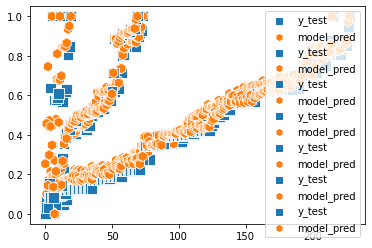

In [37]:
def ml_stats(model):
    model = load(model)
    model_pred = model.predict(X_test)
    ax0 = printing(model_pred,y_test)

    print('benchmark_1')
    chosen_bench = benchmark1
    print(sorted(chosen_bench['no_nickel'].unique()), chosen_bench['joining_type'].unique())
    
    benchmark = chosen_bench[chosen_bench['joining_type']=='MO']
    X = data_scaling(benchmark)[0]
    y = data_scaling(benchmark)[1]
    model_pred = model.predict(X)
    ax1 = printing(model_pred,y)

    benchmark = chosen_bench[chosen_bench['joining_type']=='MC']
    X = data_scaling(benchmark)[0]
    y = data_scaling(benchmark)[1]
    model_pred = model.predict(X)
    ax2 = printing(model_pred,y)

    #benchmark = chosen_bench[chosen_bench['joining_type']=='MOCM']
    #X = data_scaling(benchmark)[0]
    #y = data_scaling(benchmark)[1]
    #model_pred = model.predict(X)
    #ax3 = printing(model_pred,y)

    benchmark = chosen_bench[chosen_bench['joining_type']=='MOCOM']
    X = data_scaling(benchmark)[0]
    y = data_scaling(benchmark)[1]
    model_pred = model.predict(X)
    ax4 = printing(model_pred,y)

    benchmark = chosen_bench[chosen_bench['joining_type']=='MOCMHnbond']
    X = data_scaling(benchmark)[0]
    y = data_scaling(benchmark)[1]
    model_pred = model.predict(X)
    ax5 = printing(model_pred,y)

    print('benchmark_2')
    chosen_bench = benchmark2
    print(sorted(chosen_bench['no_nickel'].unique()), chosen_bench['joining_type'].unique())

    #benchmark = chosen_bench[chosen_bench['joining_type']=='MOCM']
    #X = data_scaling(benchmark)[0]
    #y = data_scaling(benchmark)[1]
    #model_pred = model.predict(X)
    #ax6 = printing(model_pred,y)

    benchmark = chosen_bench[chosen_bench['joining_type']=='MOCOM']
    X = data_scaling(benchmark)[0]
    y = data_scaling(benchmark)[1]
    model_pred = model.predict(X)
    ax7 = printing(model_pred,y)

    benchmark = chosen_bench[chosen_bench['joining_type']=='MOCMHnbond']
    X = data_scaling(benchmark)[0]
    y = data_scaling(benchmark)[1]
    model_pred = model.predict(X)
    ax8 = printing(model_pred,y)

    avg_b1 = (ax1[1]+ax2[1]+ax3[1]+ax4[1]+ax5[1])/5
    avg_b2 = (ax6[1]+ax7[1]+ax8[1])/3
    
    return ax0[1], avg_b1, avg_b2, ax6[1]

results = []
partial_dataset = equall_df
print(len(equall_df))
partial_dataset = equall_df[(equall_df['joining_type'] == 'MC') | (equall_df['joining_type']=='MOCM')]
print(partial_dataset['joining_type'].unique())
print(partial_dataset['no_nickel'].unique())
for i in range(1):

    X = data_scaling(partial_dataset)[0]
    y = data_scaling(partial_dataset)[1]    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25) 
    best_ada = ada(X_train,X_test,y_train,y_test)
    results.append(ml_stats('model_brf.joblib'))

avg0 = 0
avg1 = 0
avg2 = 0
avg3 = 0
for r in range(len(results)):
    avg0+=results[r][0]
    avg1+=results[r][1]
    avg2+=results[r][2]
    avg3+=results[r][3]
print('')
print(avg0/len(results))
print(avg1/len(results))
print(avg2/len(results))
print(avg3/len(results))


In [181]:
#nn printing
model = load_model('model_trained_by.h5')
model_pred = model.predict(X_test)
#printing(model_pred,y_test, nn=True)

benchmark = benchmark1
X = data_scaling(benchmark)[0]
y = data_scaling(benchmark)[1]
model_pred = model.predict(X)
test = printing(model_pred,y, nn=True)

IndexError: invalid index to scalar variable.

In [182]:
model = load('model_ada.joblib')
model_pred = model.predict(X_test)
ax0 = printing(model_pred,y_test)

print('benchmark_1')
chosen_bench = benchmark1
print(sorted(chosen_bench['no_nickel'].unique()), chosen_bench['joining_type'].unique())

benchmark = chosen_bench[chosen_bench['joining_type']=='MO']
X = data_scaling(benchmark)[0]
y = data_scaling(benchmark)[1]
model_pred = model.predict(X)
ax1 = printing(model_pred,y)

benchmark = chosen_bench[chosen_bench['joining_type']=='MC']
X = data_scaling(benchmark)[0]
y = data_scaling(benchmark)[1]
model_pred = model.predict(X)
ax2 = printing(model_pred,y)

benchmark = chosen_bench[chosen_bench['joining_type']=='MOCM']
X = data_scaling(benchmark)[0]
y = data_scaling(benchmark)[1]
model_pred = model.predict(X)
ax3 = printing(model_pred,y)

benchmark = chosen_bench[chosen_bench['joining_type']=='MOCOM']
X = data_scaling(benchmark)[0]
y = data_scaling(benchmark)[1]
model_pred = model.predict(X)
ax4 = printing(model_pred,y)

benchmark = chosen_bench[chosen_bench['joining_type']=='MOCMHnbond']
X = data_scaling(benchmark)[0]
y = data_scaling(benchmark)[1]
model_pred = model.predict(X)
ax5 = printing(model_pred,y)

print('benchmark_2')
chosen_bench = benchmark2
print(sorted(chosen_bench['no_nickel'].unique()), chosen_bench['joining_type'].unique())

benchmark = chosen_bench[chosen_bench['joining_type']=='MOCM']
X = data_scaling(benchmark)[0]
y = data_scaling(benchmark)[1]
model_pred = model.predict(X)
ax6 = printing(model_pred,y)

benchmark = chosen_bench[chosen_bench['joining_type']=='MOCOM']
X = data_scaling(benchmark)[0]
y = data_scaling(benchmark)[1]
model_pred = model.predict(X)
ax7 = printing(model_pred,y)

benchmark = chosen_bench[chosen_bench['joining_type']=='MOCMHnbond']
X = data_scaling(benchmark)[0]
y = data_scaling(benchmark)[1]
model_pred = model.predict(X)
ax8 = printing(model_pred,y)

benchmark_1
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] ['MC' 'MOCOM' 'MOCMHnbond' 'MO' 'MOCM']
benchmark_2
[1, 2, 5, 6, 8, 9, 10, 11, 12] ['MOCMHnbond' 'MOCOM' 'MOCM']


## Drawing Aproximate Accuracy Plot

In [8]:
sp_on_benchmark_cases = pd.DataFrame(data=sp_on_benchmark_cases, columns = ['full_notation','aproximate_energy','SCF_steps','magnetism','time'])
for char in range(len(sp_on_benchmark_cases)):
    sp_on_benchmark_cases['aproximate_energy'].iloc[char] = float(sp_on_benchmark_cases['aproximate_energy'].iloc[char])
benchmark_merge = real_benchmark.merge(sp_on_benchmark_cases, left_on='full_notation', right_on='full_notation')
benchmark_merge = benchmark_merge[['energy','aproximate_energy']].sort_values(by=['energy']).reset_index(drop=True)
benchmark2['joining_type'].unique()

array(['MOCMHnbond', 'MOCOM', 'MOCM'], dtype=object)

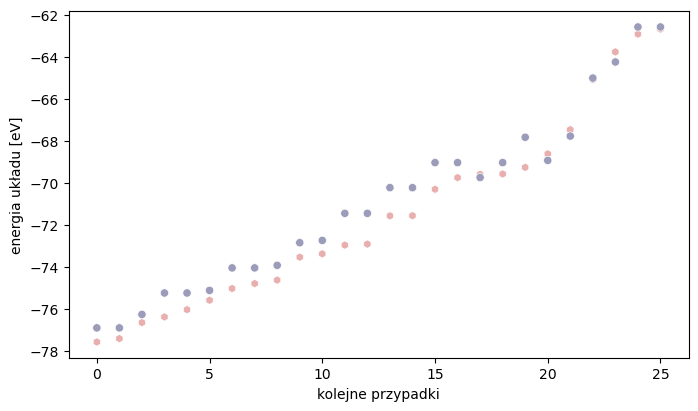

In [9]:

colors = ['#e9aeae','#9b9bba']

sns.set_palette(sns.color_palette(colors))
markers = {"energy": "h", "aproximate_energy": "o"}
plt.figure(figsize=(8,4.5))
ax = sns.scatterplot(data = benchmark_merge, markers=markers, legend= False )
ax.set_xlabel("kolejne przypadki")
ax.set_ylabel("energia układu [eV]")


f = plt.savefig('aproximate_accuracy.png')